In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection
from scipy.signal import butter,filtfilt,iirnotch
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
# emg and restimulus as tensors (E2 files only)
emg_S1 = torch.tensor(((pd.read_csv('./NinaproDB5/s1/emgS1_E2.csv')).to_numpy()), dtype=torch.int)
restimulus_S1 = torch.tensor((pd.read_csv('./NinaproDB5/s1/restimulusS1_E2.csv')).to_numpy(), dtype=torch.int)
emg_S2 = torch.tensor(((pd.read_csv('./NinaproDB5/s2/emgS2_E2.csv')).to_numpy()), dtype=torch.int)
restimulus_S2 = torch.tensor((pd.read_csv('./NinaproDB5/s2/restimulusS2_E2.csv')).to_numpy(), dtype=torch.int)
emg_S3 = torch.tensor(((pd.read_csv('./NinaproDB5/s3/emgS3_E2.csv')).to_numpy()), dtype=torch.int)
restimulus_S3 = torch.tensor((pd.read_csv('./NinaproDB5/s3/restimulusS3_E2.csv')).to_numpy(), dtype=torch.int)
emg_S4 = torch.tensor(((pd.read_csv('./NinaproDB5/s4/emgS4_E2.csv')).to_numpy()), dtype=torch.int)
restimulus_S4 = torch.tensor((pd.read_csv('./NinaproDB5/s4/restimulusS4_E2.csv')).to_numpy(), dtype=torch.int)
emg_S5 = torch.tensor(((pd.read_csv('./NinaproDB5/s5/emgS5_E2.csv')).to_numpy()), dtype=torch.int)
restimulus_S5 = torch.tensor((pd.read_csv('./NinaproDB5/s5/restimulusS5_E2.csv')).to_numpy(), dtype=torch.int)
emg_S6 = torch.tensor(((pd.read_csv('./NinaproDB5/s6/emgS6_E2.csv')).to_numpy()), dtype=torch.int)
restimulus_S6 = torch.tensor((pd.read_csv('./NinaproDB5/s6/restimulusS6_E2.csv')).to_numpy(), dtype=torch.int)
emg_S7 = torch.tensor(((pd.read_csv('./NinaproDB5/s7/emgS7_E2.csv')).to_numpy()), dtype=torch.int)
restimulus_S7 = torch.tensor((pd.read_csv('./NinaproDB5/s7/restimulusS7_E2.csv')).to_numpy(), dtype=torch.int)
emg_S8 = torch.tensor(((pd.read_csv('./NinaproDB5/s8/emgS8_E2.csv')).to_numpy()), dtype=torch.int)
restimulus_S8 = torch.tensor((pd.read_csv('./NinaproDB5/s8/restimulusS8_E2.csv')).to_numpy(), dtype=torch.int)
emg_S9 = torch.tensor(((pd.read_csv('./NinaproDB5/s9/emgS9_E2.csv')).to_numpy()), dtype=torch.int)
restimulus_S9 = torch.tensor((pd.read_csv('./NinaproDB5/s9/restimulusS9_E2.csv')).to_numpy(), dtype=torch.int)
emg_S10 = torch.tensor(((pd.read_csv('./NinaproDB5/s10/emgS10_E2.csv')).to_numpy()), dtype=torch.int)
restimulus_S10 = torch.tensor((pd.read_csv('./NinaproDB5/s10/restimulusS10_E2.csv')).to_numpy(), dtype=torch.int)

# windowing
wLen = 250 #ms
def window (e):
    return e.unfold(dimension=0, size=int(wLen / 5), step=10)

emg = torch.cat((window(emg_S1), window(emg_S2), window(emg_S3), window(emg_S4), window(emg_S5), window(emg_S6), 
                 window(emg_S7), window(emg_S8), window(emg_S9), window(emg_S10)), dim=0)
print(emg.size())

restimulus = torch.cat((window(restimulus_S1), window(restimulus_S2), window(restimulus_S3), window(restimulus_S4), 
                        window(restimulus_S5), window(restimulus_S6), window(restimulus_S7), window(restimulus_S8), 
                        window(restimulus_S9), window(restimulus_S10)), dim=0)
print(restimulus.size())

torch.Size([202319, 16, 50])
torch.Size([202319, 1, 50])


In [4]:
#delete windows with both 0's and other number (for restimulus labels)
indices = []
numLabel = {}
for x in range(len(restimulus)):
    L = torch.chunk(restimulus[x], 2, dim=1)
    if torch.equal(L[0], L[1]):
        if L[0][0][0] == 0:
            r = random.random()
            if r > 0.96:
                indices += [x]
                if 0 in numLabel:
                    numLabel[0] += 1
                else:
                    numLabel[0] = 1
        else:
            indices += [x]
            temp = int(L[0][0][0])
            if temp in numLabel:
                numLabel[temp] += 1
            else:
                numLabel[temp] = 1

emgDel = emg[indices]
restimulusDel = restimulus[indices]
print(emgDel.size())
print(restimulusDel.size())
print(numLabel)

torch.Size([74479, 16, 50])
torch.Size([74479, 1, 50])
{0: 4891, 1: 4768, 2: 3956, 3: 3984, 4: 4059, 5: 3545, 6: 3619, 7: 4174, 8: 3921, 9: 4325, 10: 4081, 11: 4649, 12: 4159, 13: 4200, 14: 3702, 15: 3335, 16: 4756, 17: 4355}


In [5]:
# contract restimulus into length 1
labels = torch.tensor((), dtype=torch.int)
labels = labels.new_zeros(size=(len(restimulusDel), 18), dtype=torch.int)
for x in range(len(restimulusDel)):
    labels[x][int(restimulusDel[x][0][0])] = 1

print(labels.size())
#print csv of labels

torch.Size([74479, 18])


In [6]:
# sixth-order Butterworth highpass filter
b, a = butter(N=3, Wn=5, btype='highpass', analog=False, fs=200.0)
emgButter = torch.from_numpy(np.flip(filtfilt(b, a, emgDel),axis=0).copy())

In [7]:
#second-order notch filter at 50 Hz
b, a = iirnotch(w0=50.0, Q=0.01, fs=200.0)
emgNotch = torch.from_numpy(np.flip(filtfilt(b, a, emgButter),axis=0).copy())

In [13]:
# feature extraction: sum of absolute values
SAV = torch.sum(torch.abs(emgNotch), dim=2)
print(SAV.size())

# feature extraction: standard deviation of fourier transform
# based on formula in section 3.2 of https://www.sciencedirect.com/science/article/pii/S0925231220303283?via%3Dihub#sec0006
emgFFT = torch.abs(torch.fft.fft(emgNotch, dim=2))
STD = torch.std(emgFFT, dim=2)
print(STD.size())

#root mean squared
RMS = torch.sqrt(torch.mean(emgNotch ** 2, dim=2))

#waveform length
diff = torch.abs(emgNotch[:, :, 1:] - emgNotch[:, :, :-1])
wl = torch.sum(diff, dim=2)
print(wl.size())

power_spectrum = torch.abs(torch.fft.fft(emgNotch, dim=2)) ** 2
sampling_frequency = 200  # sampling frequency in Hz
frequency = torch.fft.fftfreq(emgNotch.shape[2], d=1/sampling_frequency)
frequency = frequency.unsqueeze(0).unsqueeze(1)
sum_product = torch.sum(power_spectrum * frequency, dim=2)
total_sum = torch.sum(power_spectrum, dim=2)
mean_frequency = sum_product / total_sum
print(mean_frequency.size())

# combine SAV and STD
features = torch.cat((SAV, STD), dim=1)
print(features.size())

# z transform
s = preprocessing.StandardScaler().fit(features)
norm_features = torch.from_numpy(s.transform(features))
#print(norm_features)

# combine features and labels
combined = torch.cat((norm_features, labels), dim=1)

# use scikit learn to split into training set (split this into training and validation sets) and test set
train, test = model_selection.train_test_split(combined.numpy(), test_size=0.2, stratify=labels)
train, validation = model_selection.train_test_split(train, test_size=0.2)

train = torch.from_numpy(train).to(torch.float32)
validation = torch.from_numpy(validation).to(torch.float32)
test = torch.from_numpy(test).to(torch.float32)

print(train.size())
print(validation.size())
print(test.size())

torch.Size([74479, 16])
torch.Size([74479, 16])
torch.Size([74479, 16])
torch.Size([74479, 16])
torch.Size([74479, 32])
torch.Size([47666, 50])
torch.Size([11917, 50])
torch.Size([14896, 50])


In [8]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate):
        super(FullyConnectedNet, self).__init__()

        layers = []
        layer_sizes = [input_size] + hidden_sizes

        # hidden layers
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        # output layer
        layers.append(nn.Linear(layer_sizes[-1], output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# architecture parameters
input_size = 32
hidden_sizes = [512, 512]
#hidden_sizes = [512, 512, 512, 256, 256, 128, 128]
output_size = 18  # 17 gestures + 1 rest gesture
#dropout_rate = 0.2
dropout_rate = 0.5

model = FullyConnectedNet(input_size, hidden_sizes, output_size, dropout_rate)

In [9]:
class Data(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

batch_size = 64    
train_loader = DataLoader(Data(train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Data(validation), batch_size=batch_size)
test_loader = DataLoader(Data(test), batch_size=batch_size)

In [10]:
# loss function and optimizer
criterion = nn.MSELoss()
learn = 0.0003
#learn = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learn)

In [11]:
# Training loop
run = wandb.init(name='doubleEpochs', project='emg_benchmarking', entity='msoh')
wandb.config.lr = learn

num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

wandb.watch(model)

for epoch in range(num_epochs):
    model.train()
    train_acc = 0.0
    for batch_data in train_loader:
        batch_data = batch_data.to(device)

        data, labels = torch.split(batch_data, [32, 18], dim=1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)

        train_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(labels.cpu().detach().numpy(), axis=1))

        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for batch_data in val_loader:
            batch_data = batch_data.to(device)

            data, labels = torch.split(batch_data, [32, 18], dim=1)

            output = model(data)
            val_loss += criterion(output, labels).item()

            val_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(labels.cpu().detach().numpy(), axis=1))

    val_loss /= len(val_loader)
    train_acc /= len(train_loader)
    val_acc /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}")

    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss.item(),
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
    
run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: msoh. Use `wandb login --relogin` to force relogin


cuda
Epoch 1/200 | Train Loss: 0.0451 | Val Loss: 0.0422
Train Accuracy: 0.2941 | Val Accuracy: 0.4052
Epoch 2/200 | Train Loss: 0.0388 | Val Loss: 0.0395
Train Accuracy: 0.3817 | Val Accuracy: 0.4470
Epoch 3/200 | Train Loss: 0.0360 | Val Loss: 0.0379
Train Accuracy: 0.4158 | Val Accuracy: 0.4769
Epoch 4/200 | Train Loss: 0.0411 | Val Loss: 0.0366
Train Accuracy: 0.4432 | Val Accuracy: 0.4953
Epoch 5/200 | Train Loss: 0.0397 | Val Loss: 0.0358
Train Accuracy: 0.4590 | Val Accuracy: 0.5164
Epoch 6/200 | Train Loss: 0.0414 | Val Loss: 0.0350
Train Accuracy: 0.4726 | Val Accuracy: 0.5298
Epoch 7/200 | Train Loss: 0.0354 | Val Loss: 0.0346
Train Accuracy: 0.4878 | Val Accuracy: 0.5463
Epoch 8/200 | Train Loss: 0.0316 | Val Loss: 0.0339
Train Accuracy: 0.4974 | Val Accuracy: 0.5511
Epoch 9/200 | Train Loss: 0.0413 | Val Loss: 0.0333
Train Accuracy: 0.5068 | Val Accuracy: 0.5611
Epoch 10/200 | Train Loss: 0.0333 | Val Loss: 0.0332
Train Accuracy: 0.5135 | Val Accuracy: 0.5710
Epoch 11/200 |

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Acc,▁▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████████
Train Loss,▇█▆▆▆▄▆▄▅▄▆▄▅▄▅▅▄▄▄▄▃▄▆▅▃▅▅▄▄▄▂▁▄▃▄▃▂▂▄▆
Valid Acc,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
Valid Loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,199
Train Acc,0.66986
Train Loss,0.03501
Valid Acc,0.70363
Valid Loss,0.02619


Test Loss: 0.0258 | Test Accuracy: 0.7089


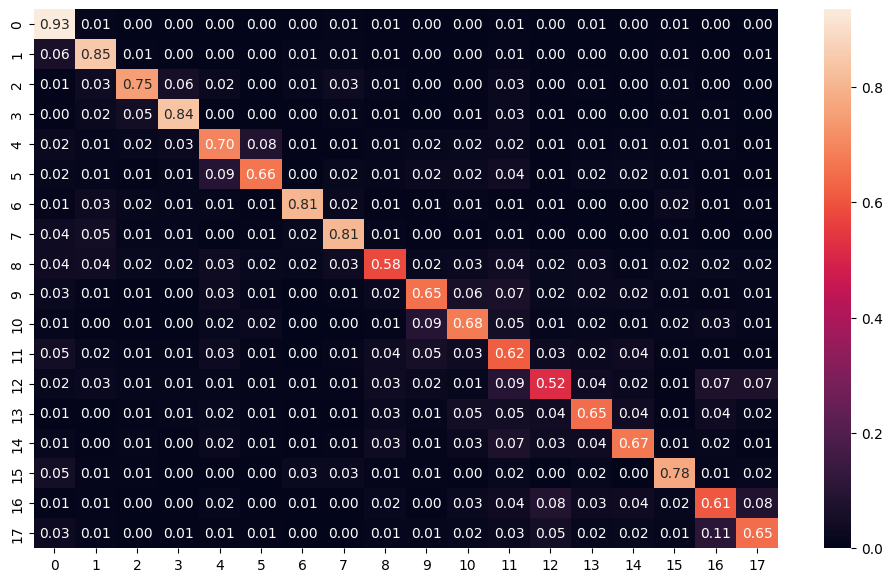

In [12]:
# Testing
pred = []
true = []

model.eval()
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():
    for batch_data in test_loader:
        batch_data = batch_data.to(device)

        data, labels = torch.split(batch_data, [32, 18], dim=1)

        output = model(data)
        test_loss += criterion(output, labels).item()

        test_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(labels.cpu().detach().numpy(), axis=1))

        output = np.argmax(output.cpu().detach().numpy(), axis=1)
        pred.extend(output)
        labels = np.argmax(labels.cpu().detach().numpy(), axis=1)
        true.extend(labels)

test_loss /= len(test_loader)
test_acc /= len(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

cf_matrix = confusion_matrix(true, pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = np.arange(0, 18, 1),
                     columns = np.arange(0, 18, 1))
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt=".2f")
plt.savefig('output.png')